# Make maps

Script for making the maps in the paper

In [ ]:
import json
import math
import os
import configparser
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FixedLocator, FixedFormatter
from tqdm import tqdm
from shapely.geometry import shape, Point, MultiPolygon
from rtree import index

sns.set(style="whitegrid")

tqdm.pandas()

In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Define the directory for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_top_epochs=0_num_full_epochs=20')
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with predictions
df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

In [3]:
df.groupby('region_id').mean()

,lon,lat,rural,month,year,iwi,iwi_hat,train_score,val_score
region_id,,,,,,,,,
AO.Bengo,13.908061,-8.435568,0.636364,5.575758,2015.575758,34.948254,31.057923,-0.005341,-0.000025
AO.Benguela,13.858086,-12.736620,0.363636,8.303030,2015.272727,34.467082,38.960760,-0.007805,-0.005297
AO.Bié,17.012872,-12.007002,0.625000,4.406250,2015.687500,22.730280,25.265740,0.029448,0.043404
AO.Cabinda,12.254070,-5.477956,0.181818,5.212121,2015.636364,60.380207,56.435070,-0.042244,-0.048862
AO.Cuando Cubango,18.608551,-15.454207,0.484848,4.848485,2015.666667,25.197943,27.614106,0.044026,0.051065
...,...,...,...,...,...,...,...,...,...
ZW.Matabeleland North,27.655321,-18.835474,0.775281,8.101124,2010.157303,24.828918,24.588807,0.000828,0.013781
ZW.Matabeleland South,28.904847,-21.066943,0.804598,8.494253,2009.816092,26.977507,24.926965,-0.002572,0.009375
ZW.Matebeleland North,27.706581,-18.847011,0.900000,6.533333,2005.300000,14.647692,22.478565,-0.001843,0.014681


In [ ]:
aid_data_dir = os.path.join(DATA_DIR, 'aid_data')

shapes = []
properties = []
with fiona.open(os.path.join(aid_data_dir, 'data/country_regions/gadm2_clean.shp')) as shp:
    for feature in tqdm(shp):
        geom = shape(feature['geometry'])
        shapes.append(geom)
        properties.append(feature['properties'])

100%|██████████| 47041/47041 [00:57<00:00, 816.11it/s] 


In [ ]:
gdf = gpd.GeoDataFrame(properties, geometry=shapes)

african_iso3_codes = [
    "DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", "CAF", "TCD", "COM",
    "COG", "COD", "DJI", "EGY", "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA",
    "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "LBY", "MDG", "MWI", "MLI", "MRT",
    "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE",
    "SOM", "ZAF", "SSD", "SDN", "TZA", "TGO", "TUN", "UGA", "ZMB", "ZWE", "ESH"
]


africa_gdf = gdf[gdf['ISO'].isin(african_iso3_codes)].reset_index(drop=True)

africa_gdf

,ID_adm2,ISO,part_area,geometry
0,c118r10r56,KEN,4314.533876,"POLYGON ((36.79758 -2.55378, 36.79652 -2.55324..."
1,c118r10r57,KEN,3268.699270,"POLYGON ((37.67785 -2.25568, 37.67780 -2.25577..."
2,c118r10r58,KEN,112.345759,"POLYGON ((36.78143 -1.38591, 36.78157 -1.38597..."
3,c118r10r59,KEN,6357.609501,"POLYGON ((37.85370 -3.16922, 37.85369 -3.16931..."
4,c118r10r60,KEN,7940.396335,"POLYGON ((36.67472 -1.74086, 36.67267 -1.75022..."
...,...,...,...,...
6133,c97r8r30,GIN,4236.501539,"POLYGON ((-10.40708 8.45314, -10.40715 8.45300..."
6134,c97r8r31,GIN,4476.916810,"POLYGON ((-8.47218 7.55458, -8.48715 7.57121, ..."
6135,c97r8r32,GIN,8055.817327,"POLYGON ((-9.16320 7.93243, -9.17117 7.92128, ..."
6136,c97r8r33,GIN,4054.517644,"POLYGON ((-8.72145 7.49459, -8.72686 7.48956, ..."


Plot all ADM2 regions

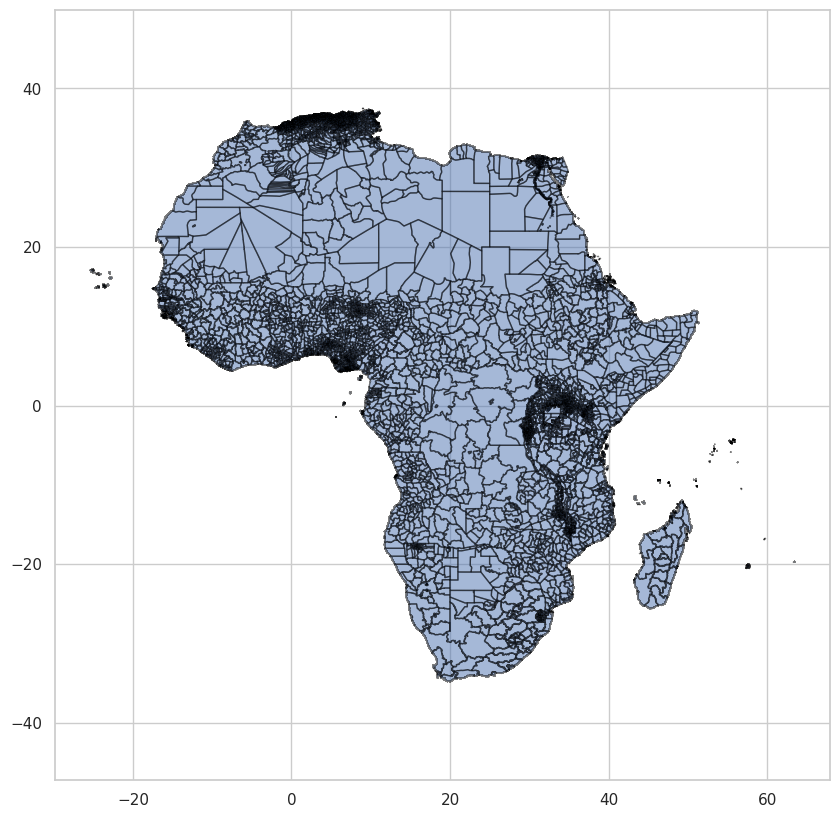

In [6]:
africa_gdf.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
plt.axis('equal')
plt.show()

In [7]:
idx = index.Index()
for i, geom in enumerate(shapes):
    idx.insert(i, geom.bounds)

In [8]:
def find_region(lat, lon):
    point = Point(lon, lat)

    # Try to find containing polygon
    candidates = list(idx.intersection((lon, lat, lon, lat)))
    for i in candidates:
        if shapes[i].contains(point):
            return properties[i]  # return ADM2 properties

    # If not found, find the nearest polygon
    min_dist = math.inf
    nearest_i = None
    for i in idx.nearest((lon, lat, lon, lat), 5):  # Try 5 nearest first
        dist = point.distance(shapes[i])
        if dist < min_dist:
            min_dist = dist
            nearest_i = i
    return properties[nearest_i] if nearest_i is not None else None

In [9]:
df['ID_adm2'] = df.progress_apply(lambda row: find_region(row['lat'], row['lon']).get('ID_adm2'), axis=1)

100%|██████████| 68619/68619 [04:56<00:00, 231.53it/s] 


In [10]:
df['residual'] = df['iwi_hat'] - df['iwi']
df['tweedie_correction'] = df.apply(lambda row: -(correction_values[row['cv_fold']]['train_sigma'] ** 2) * row['train_score'], axis=1)
adm2_df = df.groupby('ID_adm2').mean()
adm2_df

,lon,lat,rural,month,year,iwi,iwi_hat,train_score,val_score,residual,tweedie_correction
ID_adm2,,,,,,,,,,,
c118r10r56,36.810456,-2.131263,0.769231,6.153846,2016.076923,30.075351,23.799800,0.012313,0.028063,-6.275551,-0.367316
c118r10r57,36.982422,-1.603496,0.318182,6.636364,2018.363636,45.327017,41.576794,-0.006996,-0.008488,-3.750223,0.328050
c118r10r58,36.721241,-1.391484,0.115385,5.038462,2016.115385,49.245733,48.154164,-0.013590,-0.021129,-1.091568,0.434650
c118r10r59,37.502894,-2.800207,0.846154,7.000000,2016.230769,26.780810,25.456734,-0.015568,-0.006762,-1.324076,0.496354
c118r10r60,36.399009,-1.583137,0.785714,6.428571,2018.714286,22.869641,26.297177,0.020518,0.028499,3.427536,-0.466179
...,...,...,...,...,...,...,...,...,...,...,...
c97r8r30,-10.283874,8.606118,0.739130,5.869565,2009.500000,19.700926,18.707890,0.043335,0.058407,-0.993036,-1.503752
c97r8r31,-8.431906,7.884612,0.800000,6.200000,2011.500000,22.068867,21.612134,0.041695,0.053342,-0.456733,-1.117235
c97r8r32,-9.353269,8.407812,0.777778,6.083333,2009.333333,18.891819,20.739335,0.021505,0.036973,1.847516,-0.734469


Get an outline to improve the map plots

In [11]:
africa_outline = africa_gdf.dissolve()  # dissolve all into one geometry

# Explode into individual polygons
outline_parts = africa_outline.explode(index_parts=False)

# Filter by area (e.g., keep polygons > some threshold)
area_threshold = 1e1  # Adjust as needed (in square meters if CRS is meters)
outline_filtered = outline_parts[outline_parts.area > area_threshold]

# Recombine into one MultiPolygon
filtered_geom = outline_filtered.unary_union
if isinstance(filtered_geom, MultiPolygon):
    filtered_outline_gdf = gpd.GeoDataFrame(geometry=[filtered_geom], crs=africa_gdf.crs)
else:
    filtered_outline_gdf = gpd.GeoDataFrame(geometry=[filtered_geom], crs=africa_gdf.crs)

simplified_outline = filtered_outline_gdf.copy()
simplified_outline['geometry'] = simplified_outline.simplify(tolerance=0.2, preserve_topology=True)

/local/tmp.5458424/ipykernel_153507/1025562638.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


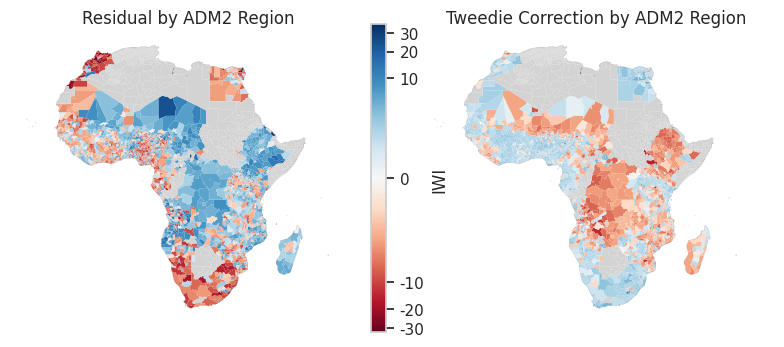

In [ ]:
# Merge with Africa GeoDataFrame
plot_gdf = africa_gdf.merge(adm2_df, left_on='ID_adm2', right_index=True, how='left')

# Define transformation
def signed_cuberoot(x):
    return np.sign(x) * np.abs(x)**(1/3)

# Inverse transformation (for labeling)
def inv_signed_cuberoot(x):
    return np.sign(x) * np.abs(x)**3

# Transform data
for col in ['residual', 'tweedie_correction']:
    plot_gdf[f'{col}_transformed'] = signed_cuberoot(plot_gdf[col])

columns = ['residual_transformed', 'tweedie_correction_transformed']

# Set common color scale based on transformed data
vmin = min(plot_gdf[columns].min())
vmax = max(plot_gdf[columns].max())
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cmap = 'RdBu'

for ax, column, title in zip(axes, columns, ['Residual by ADM2 Region', 'Tweedie Correction by ADM2 Region']):
    plot_gdf.plot(
        column=column,
        cmap=cmap,
        ax=ax,
        edgecolor='none',
        norm=norm,
        legend=False,
        missing_kwds={
            'color': 'lightgray',
            'label': 'Missing data'
        }
    )
    ax.set_title(title)
    simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)
    ax.axis('off')

# Add shared colorbar with original IWI scale labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Choose original-scale ticks (e.g., in IWI or raw residual units)
iwi_tick_labels = [-30, -20, -10, 0, 10, 20, 30]  # you can modify this range
transformed_ticks = [signed_cuberoot(x) for x in iwi_tick_labels]

cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.55, pad=0.05)
cbar.set_label('IWI')
cbar.set_ticks(transformed_ticks)
cbar.set_ticklabels(iwi_tick_labels)

# Show and save
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'res_and_tweedie_by_adm2_labeled.svg'), bbox_inches='tight')
plt.show()


## Plot interventions df

Using country shapes from https://open.africa/dataset/africa-shapefiles/resource/dcdadd25-0137-4c93-ae5a-82b39d424d60

In [15]:
aid_data_dir = os.path.join(DATA_DIR, 'aid_data')
interventions_df = pd.read_csv(os.path.join(aid_data_dir, 'interim/interventions.csv'))
interventions_df

,project_id,project_location_id,country,latitude,longitude,start_date,funder,ad_sector_codes,sector_group_name
0,31023,31023_11550981,Kenya,0.89333,36.30833,2013-01-01,CH,230,Economic Infrastructure & Services
1,31023,31023_11550982,Kenya,0.19306,36.07000,2013-01-01,CH,230,Economic Infrastructure & Services
2,23142,23142_158684,Tanzania,-2.63861,30.46778,2009-07-24,CH,220,Economic Infrastructure & Services
3,23142,23142_150387,Tanzania,-2.38500,30.78583,2009-07-24,CH,220,Economic Infrastructure & Services
4,23142,23142_161154,Tanzania,-2.63194,31.30889,2009-07-24,CH,220,Economic Infrastructure & Services
...,...,...,...,...,...,...,...,...,...
22202,P128768,P128768_2362344,Burkina Faso,11.17715,-4.29790,2013-07-30,WB,230,Economic Infrastructure & Services
22203,P128768,P128768_2360886,Burkina Faso,12.06157,0.35843,2013-07-30,WB,230,Economic Infrastructure & Services
22204,P128768,P128768_2359608,Burkina Faso,13.09167,-1.08444,2013-07-30,WB,230,Economic Infrastructure & Services
22205,P128768,P128768_2357043,Burkina Faso,13.58278,-2.42158,2013-07-30,WB,230,Economic Infrastructure & Services


In [ ]:
plot_gdf.plot(
    column=column,
    cmap=cmap,
    ax=ax,
    edgecolor='none',
    norm=norm,
    legend=False,
    missing_kwds={
        'color': 'lightgray',
        'label': 'Missing data'
    }
)
ax.set_title(title)
simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)
ax.axis('off')
plt.show()

In [22]:
interventions_geo = [Point(lon, lat) for lon, lat in zip(interventions_df['longitude'], interventions_df['latitude'])]
interventions_gdf = gpd.GeoDataFrame(interventions_df, geometry=interventions_geo, crs="EPSG:4326")

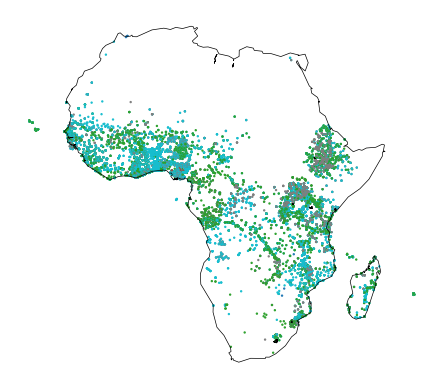

In [86]:
ax = interventions_gdf.plot(
    column="sector_group_name",
    cmap="tab10",
    markersize=0.5
    )
simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.axis('off')
# plt.legend()
plt.show()

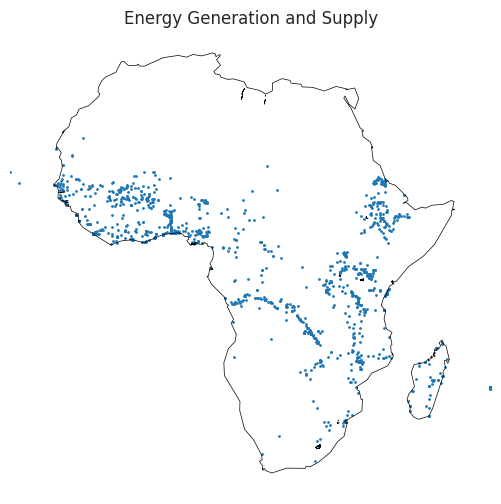

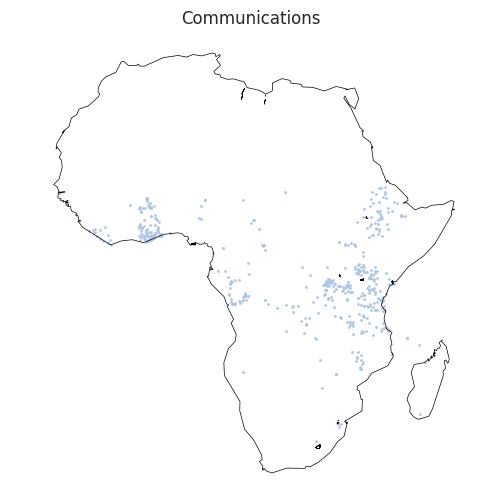

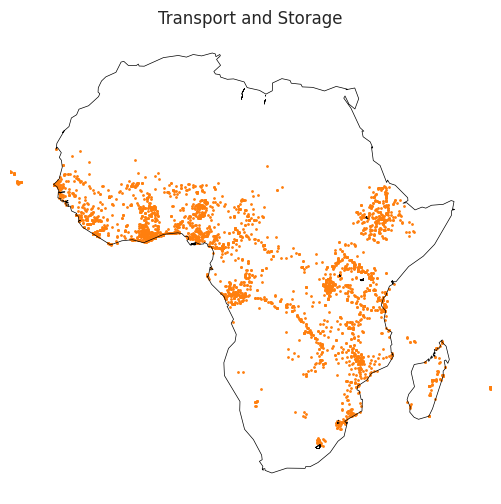

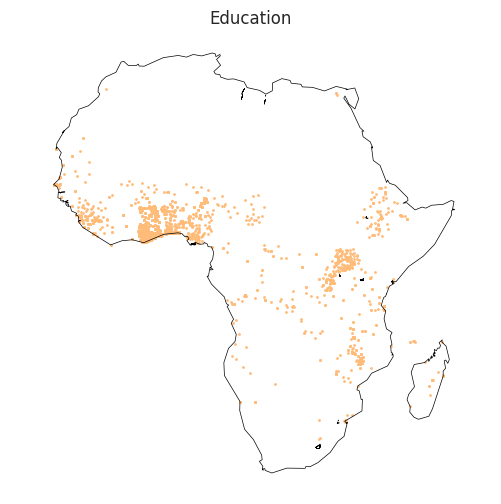

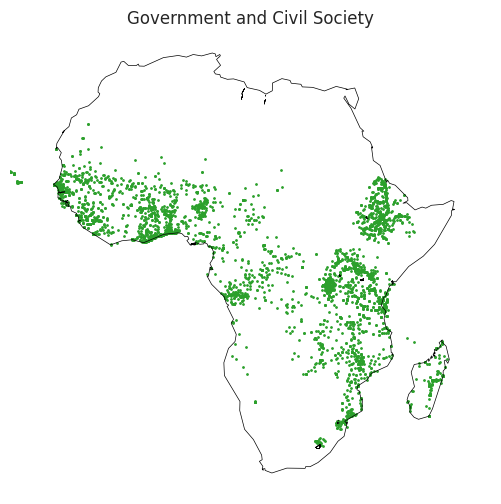

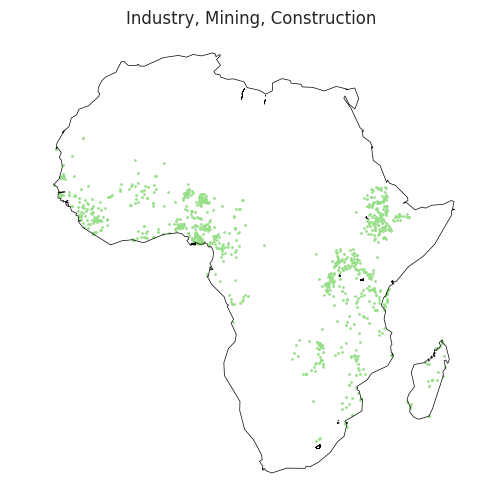

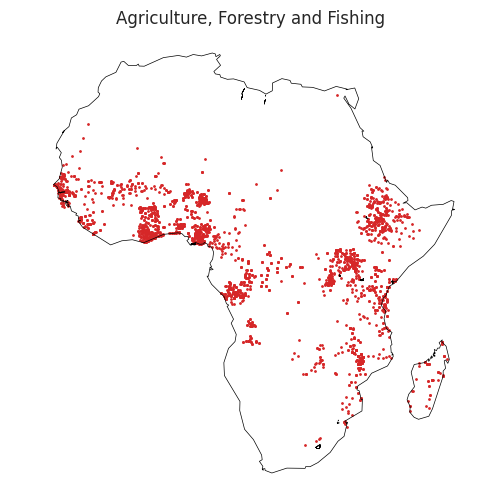

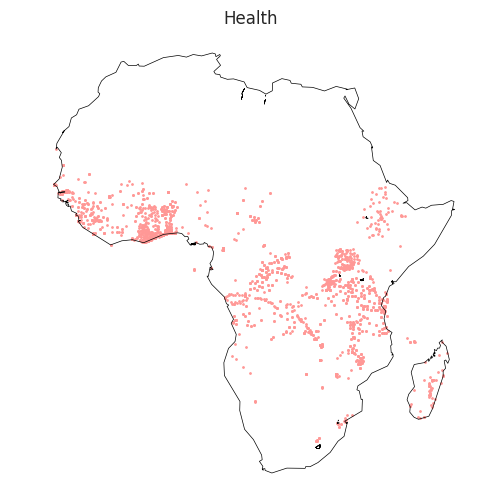

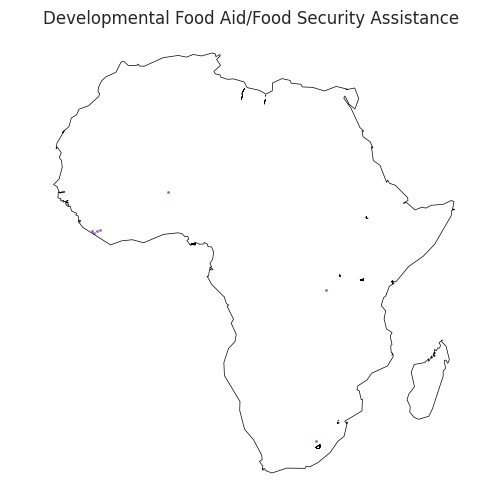

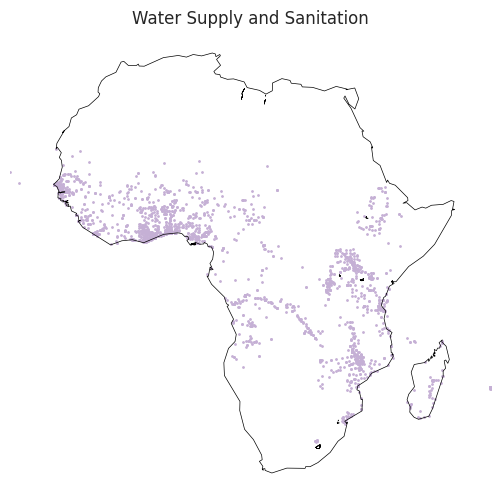

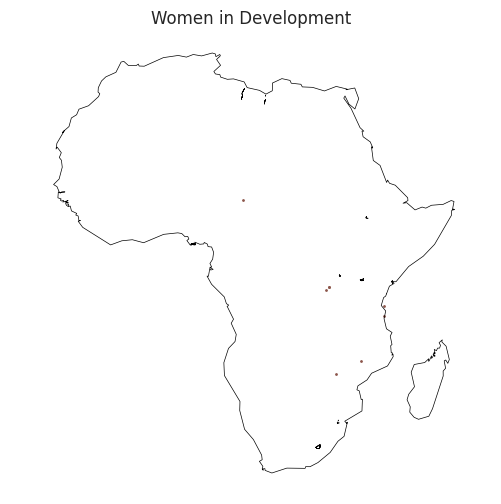

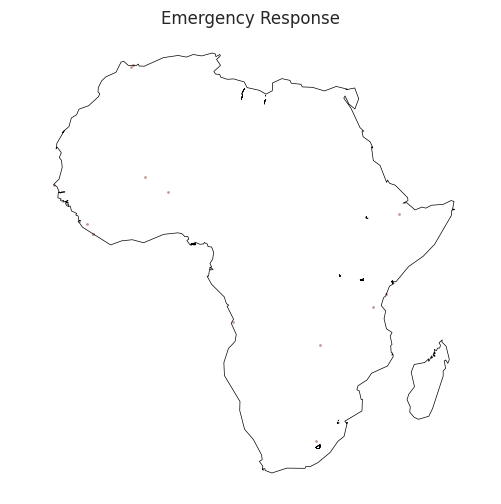

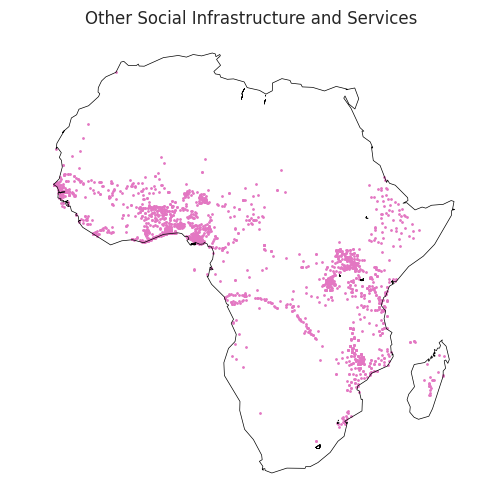

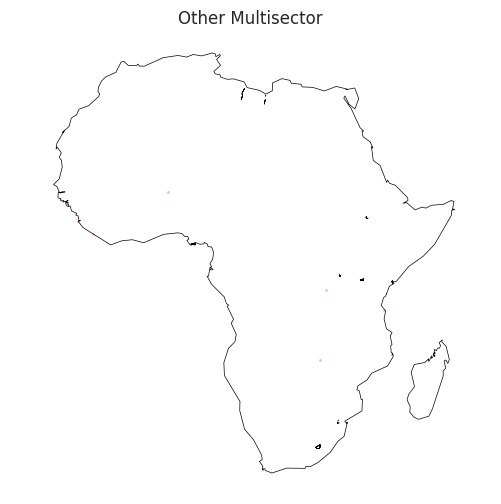

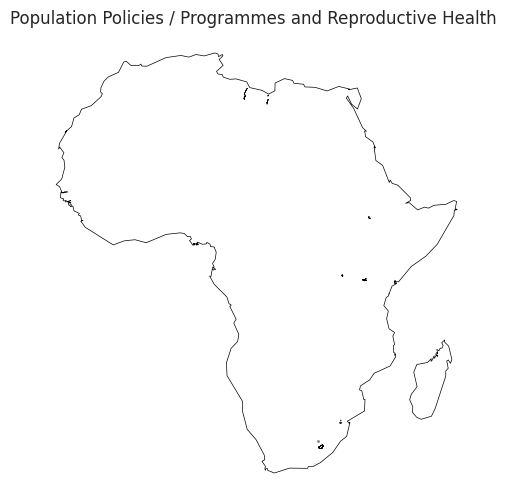

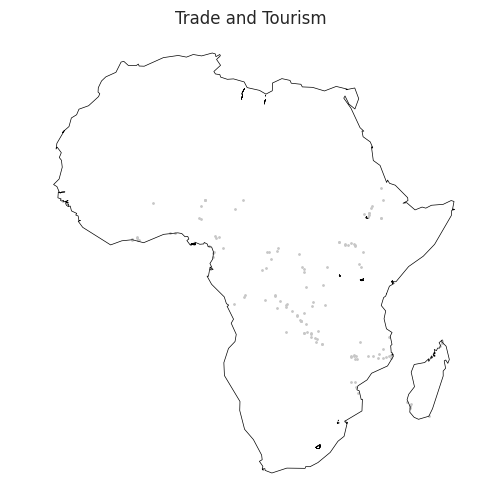

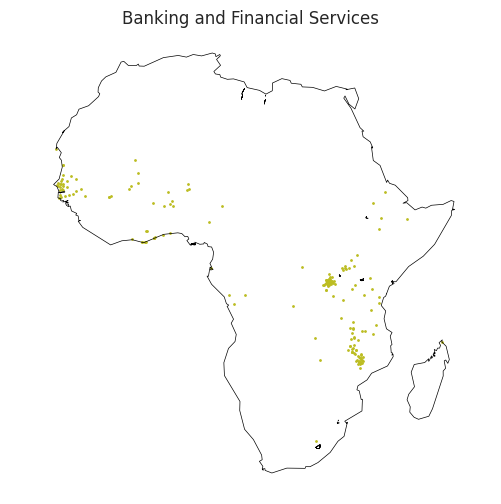

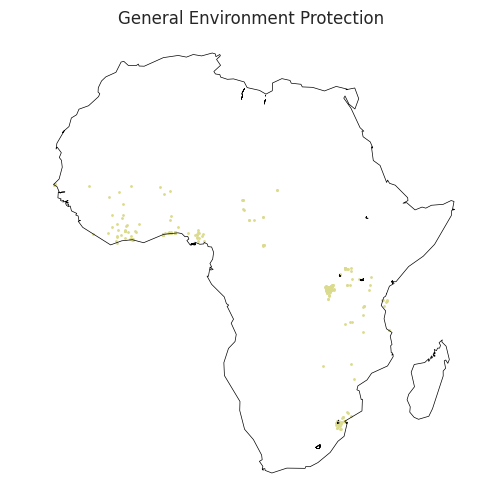

In [ ]:
os.makedirs(os.path.join(aid_data_dir, 'ad_sector_maps'), exist_ok=True)

# Only includes the sector codes used in the analysis
ad_sector_code_dict = {
    230: 'Energy Generation and Supply',
    220: 'Communications',
    210: 'Transport and Storage',
    110: 'Education',
    150: 'Government and Civil Society',
    320: 'Industry, Mining, Construction',
    310: 'Agriculture, Forestry and Fishing',
    120: 'Health',
    520: 'Developmental Food Aid/Food Security Assistance',
    140: 'Water Supply and Sanitation',
    420: 'Women in Development',
    700: 'Emergency Response',
    160: 'Other Social Infrastructure and Services',
    430: 'Other Multisector',
    130: 'Population Policies / Programmes and Reproductive Health',
    330: 'Trade and Tourism',
    240: 'Banking and Financial Services',
    410: 'General Environment Protection'
}

# Create a color map: one color per category
cmap = plt.get_cmap('tab20')
colors = {cat: cmap(i) for i, cat in enumerate(ad_sector_code_dict)}

# Determine the global xlim
all_x_values = interventions_gdf.geometry.x
x_min, x_max = all_x_values.min(), all_x_values.max()

for ad_sector_code in ad_sector_code_dict:
    fig, ax = plt.subplots(figsize=(8, 6))
    subset = interventions_gdf[interventions_gdf["ad_sector_codes"] == ad_sector_code]
    plt.scatter(
        subset.geometry.x,
        subset.geometry.y,
        color=colors[ad_sector_code],
        label=ad_sector_code_dict[ad_sector_code],
        s=1.0
    )

    ax.set_xlim(x_min, x_max)
    plt.title(ad_sector_code_dict[ad_sector_code])

    simplified_outline.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    ax.axis('off')
    plt.savefig(os.path.join(aid_data_dir, 'ad_sector_maps', f'{ad_sector_code}.svg'))
    plt.show()
